<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#compare-the-fft-and-2nd-order-structure-function" data-toc-modified-id="compare-the-fft-and-2nd-order-structure-function-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>compare the fft and 2nd order structure function</a></span><ul class="toc-item"><li><span><a href="#use-numba-to-speed-up-the-calculation" data-toc-modified-id="use-numba-to-speed-up-the-calculation-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>use numba to speed up the calculation</a></span></li><li><span><a href="#Compare-fft-and-2nd-order-sf-on-aircraft-data-from" data-toc-modified-id="Compare-fft-and-2nd-order-sf-on-aircraft-data-from-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Compare fft and 2nd order sf on aircraft data from</a></span></li></ul></li></ul></div>

# compare the fft and 2nd order structure function

In [22]:
from a500.utils.data_read import download
import numpy as np
from matplotlib import pyplot as plt
import os
from numba import jit
#pip install contexttimer
import contexttimer
import time

## use numba to speed up the calculation

In [1]:
#@jit(nopython=True)
def calc_sf2(vector,num_seps):
    """
    calculate the 2nd order structure function
    
    Parameters
    ----------
    
    vector: float32 ndarray
       one-d array of data
       
    num_seps: int
       the number of steps you want to calculate the differences over
       (i.e. num_seps=500 will calculate all differences up to an index separation of 500)
       
    Returns
    -------
    
    (accum, count): (ndarray,ndarry)
        tuple of ndarrays containg the 2nd order structure function
        and the number of data points at each separation
    
    """
    totvals=len(vector)
    accum=totvals
    halfvals = np.int32(totvals/2.)
    spacing = np.arange(1,halfvals,1,np.int32)
    accum= np.zeros(spacing.shape,dtype=np.float32)
    count = np.zeros(spacing.shape,np.int32)
    for accum_index,the_sep in enumerate(spacing[:num_seps]):
        vals=np.arange(the_sep,halfvals,1,np.int32)
        for vec_index in vals:
             accum[accum_index] = accum[accum_index] + \
                (vector[vec_index] - vector[vec_index - the_sep])**2.
             count[accum_index] = count[accum_index] + 1
        accum[accum_index] = accum[accum_index]/count[accum_index]
    return accum[:num_seps],count[:num_seps]

## Compare fft and 2nd order sf on aircraft data from 

In [31]:
download('aircraft.npz',root='http://clouds.eos.ubc.ca/~phil/docs/atsc500/data')
data = np.load('aircraft.npz')
wvel = data['wvel']
wvel = wvel - np.mean(wvel)
print(wvel.dtype)
with contexttimer.Timer(time.perf_counter) as pure_wall:
    with contexttimer.Timer(time.process_time) as pure_cpu:
        sf2,count=calc_sf2(wvel,30)   
print(f'pure python wall time {pure_wall.elapsed} and cpu time {pure_cpu.elapsed}')



trying http://clouds.eos.ubc.ca/~phil/docs/atsc500/data/aircraft.npz
writing to: aircraft.npz

aircraft.npz already exists
and is 732584 bytes
will not overwrite

float32
pure python wall time 0.00948234400129877 and cpu time 0.007358999999993898


In [4]:
download('miami_tower.npz',root='http://clouds.eos.ubc.ca/~phil/docs/atsc500/data')
td=np.load('miami_tower.npz') #load temp, uvel, vvel, wvel, minutes
print('keys: ',td.keys())
#print(td['description'])
wvel= td['wvel'].flatten()
wvel = wvel - np.mean(wvel)
wvel=wvel.astype(np.float32)
print(wvel.dtype)
print(wvel.shape)
sf2,count=calc_sf2(wvel,999) 

trying http://clouds.eos.ubc.ca/~phil/docs/atsc500/data/miami_tower.npz
writing to: miami_tower.npz

miami_tower.npz already exists
and is 1503441 bytes
will not overwrite

keys:  ['wvel', 'vvel', 'minutes', 'temp', '__header__', 'description', 'uvel', '__globals__', '__version__']
float32
(37501,)


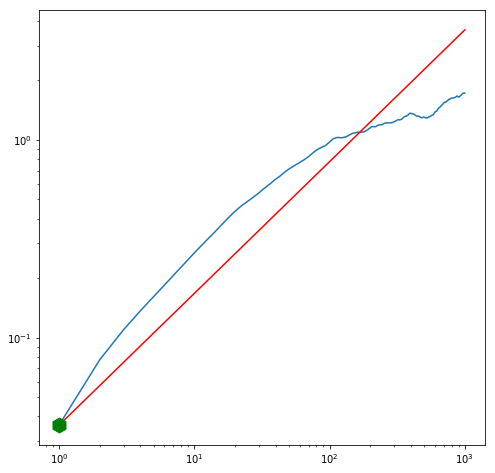

In [5]:
sep_vals=np.arange(1,1000,dtype=np.float)
fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.loglog(sep_vals,sf2)
leftspec=np.log10(sf2[0])
logy=leftspec + 2./3.*np.log10(sep_vals)
yvals=10.**logy
ax.loglog(sep_vals,yvals,'r-')
thePoint=ax.plot(1.,sf2[0],'g+')
thePoint[0].set_markersize(15)
thePoint[0].set_marker('h')
thePoint[0].set_markerfacecolor('g')

In [6]:
sampleRate=25.
nyquistfreq=sampleRate/2.


totsize=36000
wvel=wvel[0:totsize].flatten()
wvel = wvel - np.mean(wvel)

halfpoint=np.int(np.floor(totsize/2.))
frequencies=np.arange(0,halfpoint)
frequencies=frequencies/halfpoint
frequencies=frequencies*nyquistfreq


In [7]:
thefft=np.fft.fft(wvel)
Power=np.real(thefft*np.conj(thefft))
thefft=np.fft.fft(wvel)
Power=np.real(thefft*np.conj(thefft))
print('check Wiener-Khichine theorem for wvel')
print('\nraw fft sum, full time series: %10.4f\n' % (np.sum(Power)/totsize**2.))
print('velocity variance: %10.4f\n' % (np.sum(wvel*wvel)/totsize))

check Wiener-Khichine theorem for wvel

raw fft sum, full time series:     1.0337

velocity variance:     1.0337



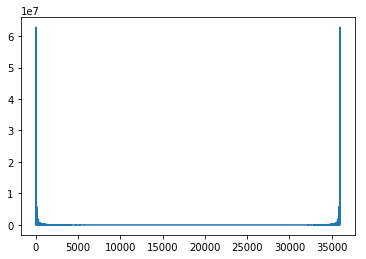

In [8]:
plt.plot(Power)

/Users/phil/mini36/lib/python3.6/site-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


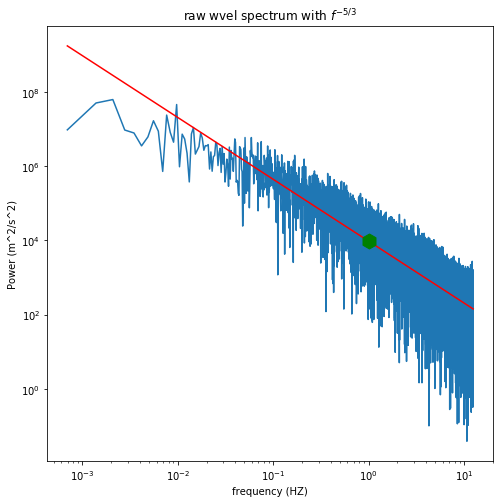

In [9]:
fig,theAx=plt.subplots(1,1,figsize=(8,8))
frequencies[0]=np.NaN
Power[0]=np.NaN
Power_half=Power[:halfpoint:]
theAx.loglog(frequencies,Power_half)
theAx.set_title('raw wvel spectrum with $f^{-5/3}$')
theAx.set(xlabel='frequency (HZ)',ylabel='Power (m^2/s^2)')
#
leftspec=np.log10(Power[1]*1.e-3)
logy=leftspec - 5./3.*np.log10(frequencies)
yvals=10.**logy
theAx.loglog(frequencies,yvals,'r-')
thePoint=theAx.plot(1.,Power[1]*1.e-3,'g+')
thePoint[0].set_markersize(15)
thePoint[0].set_marker('h')
thePoint[0].set_markerfacecolor('g')




Try a windowed spectrum (Bartlett window)

sumw:      0.533


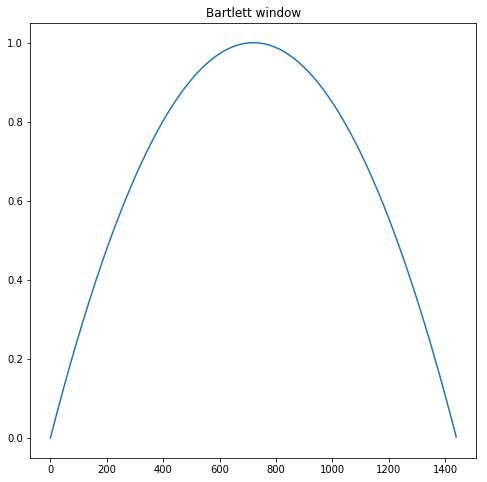

In [10]:
print('\n\n\nTry a windowed spectrum (Bartlett window)\n')
## windowing -- see p. Numerical recipes 550 for notation

def calc_window(numvals=1440):
    """
      Calculate a Bartlett window following
      Numerical Recipes 13.4.13
    """
    
    halfpoint=int(np.floor(numvals/2.))
    facm=halfpoint
    facp=1/facm

    window=np.empty([numvals],np.float)
    for j in np.arange(numvals):
        window[j]=(1.-((j - facm)*facp)**2.)
    return window

#
#  we need to normalize by the squared weights
#  (see the fortran code on Numerical recipes p. 550)
#
numvals=1440
window=calc_window(numvals=numvals)
sumw=np.sum(window**2.)/numvals
fig,theAx=plt.subplots(1,1,figsize=(8,8))
theAx.plot(window)
theAx.set_title('Bartlett window')
print('sumw: %10.3f' % sumw)

In [11]:
def do_fft(the_series,window,ensemble=25,title='title'):
    numvals=len(window)
    sumw=np.sum(window**2.)/numvals
    subset=the_series.copy()
    subset=subset[:len(window)*ensemble]
    subset=np.reshape(subset,(ensemble,numvals))
    winspec=np.zeros([numvals],np.float)

    for therow in np.arange(ensemble):
        thedat=subset[therow,:]
        thefft =np.fft.fft(thedat*window)
        Power=thefft*np.conj(thefft)
        #print('\nensemble member: %d' % therow)
        #print('\nwindowed fft sum (m^2/s^2): %10.4f\n' % (np.sum(Power)/(sumw*numvals**2.),))
        #print('velocity variance (m^2/s^2): %10.4f\n\n' % (np.sum(thedat*thedat)/numvals,))
        winspec=winspec + Power

    winspec=np.real(winspec/(numvals**2.*ensemble*sumw))
    return winspec

In [12]:
winspec=do_fft(wvel,window)
sampleRate=25
nyquistfreq=sampleRate/2.
halfpoint=int(len(winspec)/2.)
averaged_freq=np.linspace(0,1.,halfpoint)*nyquistfreq   
winspec=winspec[0:halfpoint]

/Users/phil/mini36/lib/python3.6/site-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


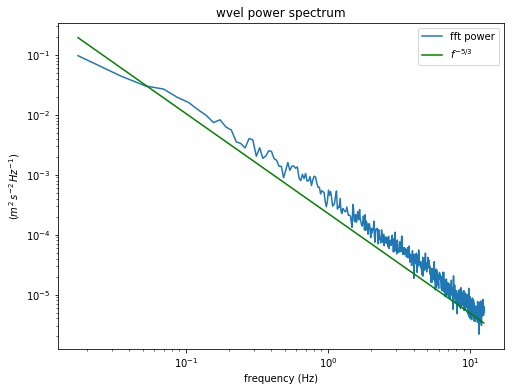

In [13]:
def do_plot(the_freq,the_spec,title=None,ylabel=None):
    the_freq[0]=np.NaN
    the_spec[0]=np.NaN
    fig,theAx=plt.subplots(1,1,figsize=(8,6))
    theAx.loglog(the_freq,the_spec,label='fft power')
    if title:
        theAx.set_title(title)
    leftspec=np.log10(the_spec[int(np.floor(halfpoint/10.))])
    logy=leftspec - 5./3.*np.log10(the_freq)
    yvals=10.**logy
    theAx.loglog(the_freq,yvals,'g-',label='$f^{-5/3}$')
    theAx.set_xlabel('frequency (Hz)')
    if ylabel:
        out=theAx.set_ylabel(ylabel)
    out=theAx.legend(loc='best')
    return theAx

labels=dict(title='wvel power spectrum',ylabel='$(m^2\,s^{-2}\,Hz^{-1})$')
ax=do_plot(averaged_freq,winspec,**labels)
 